## Before running this notebook
If you have an old version of jupyter notebook, it's required to activate ipywidgets 

`jupyter nbextension enable --py widgetsnbextension`

In [1]:
from matplotlib.colors import ListedColormap
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import ipywidgets as widgets
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from lossesUtils import categorical_focal_loss
from bandUtils import Band
from convNetUtils import predict_on_raster, predict_label_category_on_raster
from labelsUtils import Label, LabelCategory, category_from_label, CATEGORIES_LABELS
from visualizationUtils import label_first_detections
from regionUtils import vietnam_labels_coordinates
from rasterUtils import create_image_metadata
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
IMAGE_SIZE = 9
labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [3]:
model_name = "january_to_april_2018_multi_output_focal_loss_collection2_new_categories"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'january_to_april_2018_multi_output_focal_loss_collection2_new_categories.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
year_label_predictions = []
year_category_predictions = []
year_img_indices = []

for year in range(14, 22):
    print(f"20{year} ...")
    raster_path = os.path.join(DATA_ROOT_PATH, "Vietnam_20{}_january_to_april_collection2/merged.tif".format(year))
    label_predictions, category_predictions, img_indices = predict_label_category_on_raster(model, raster_path, bands, IMAGE_SIZE)
    
    year_label_predictions.append(label_predictions)
    year_category_predictions.append(category_predictions)
    year_img_indices.append(img_indices)

2014 ...
Image width: 16708
Image height: 7422
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2015 ...
Image width: 16708
Image height: 7422
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2016 ...
Image width: 16708
Image height: 7422
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2017 ...
Image width: 16708
Image height: 7422
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2018 ...
Image width: 16708
Image height: 7422
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, so

In [5]:
row_indices = [
    [indices[0] for indices in year_img_indices[year]]
    for year in range(len(year_label_predictions))
]

col_indices = [
    [indices[1] for indices in year_img_indices[year]]
    for year in range(len(year_label_predictions))
] 

df_list = [
    pd.DataFrame(data=dict({
        'image row': row_indices[year - 14],
        'image col': col_indices[year - 14],
        'label_predicted': year_label_predictions[year - 14],
        'category_predicted': year_category_predictions[year - 14]
    })).assign(year=int("20" + str(year)))
    for year in range(14, 22)
]

# Concatenate all those dataframe into one
concat_df = pd.concat(df_list)

In [6]:
concat_df.to_csv(os.path.join(DATA_ROOT_PATH, 'final_predictions_january_to_april_2014_2021.csv'), index=False)

In [7]:
concat_df = pd.read_csv(os.path.join(DATA_ROOT_PATH, 'final_predictions_january_to_april_2014_2021.csv'))

In [8]:
concat_df

,image row,image col,label_predicted,category_predicted,year
0,0,358,1,1,2014
1,0,359,14,4,2014
2,0,360,1,1,2014
3,0,361,1,1,2014
4,0,362,1,1,2014
...,...,...,...,...,...
9596985,1855,253,0,0,2021
9596986,1855,254,2,0,2021
9596987,1855,255,2,0,2021
9596988,1855,256,2,0,2021


In [9]:
concat_df.groupby('year').agg(['count'])

,image row,image col,label_predicted,category_predicted
,count,count,count,count
year,,,,
2014,1200345,1200345,1200345,1200345
2015,1199577,1199577,1199577,1199577
2016,1200316,1200316,1200316,1200316
2017,1199601,1199601,1199601,1199601
2018,1198455,1198455,1198455,1198455
2019,1199366,1199366,1199366,1199366
2020,1200319,1200319,1200319,1200319
2021,1199011,1199011,1199011,1199011


In [10]:
total_per_year_df = concat_df.groupby('year').agg(count=pd.NamedAgg(column='label_predicted', aggfunc='value_counts')).reset_index()

In [11]:
total_per_year_df

,year,label_predicted,count
0,2014,1,334352
1,2014,0,219319
2,2014,10,110630
3,2014,2,108321
4,2014,14,63794
...,...,...,...
131,2021,12,28822
132,2021,7,16189
133,2021,9,9527
134,2021,13,1611


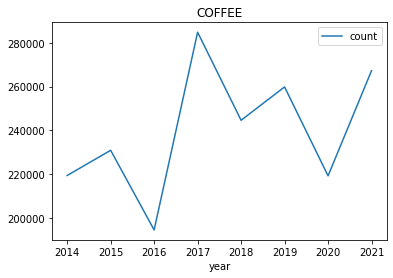

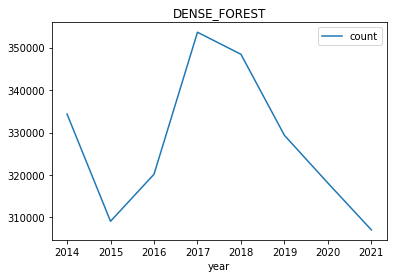

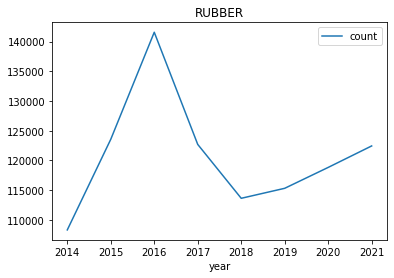

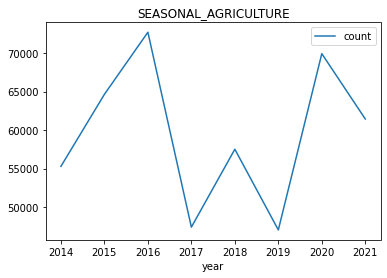

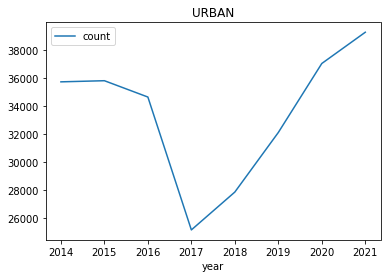

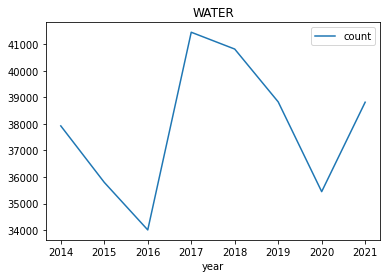

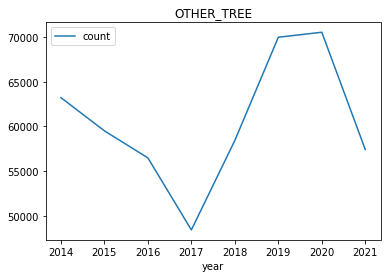

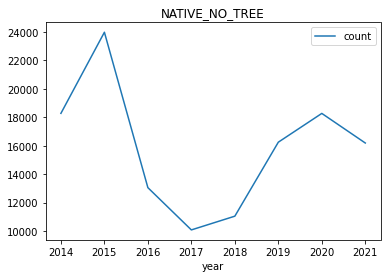

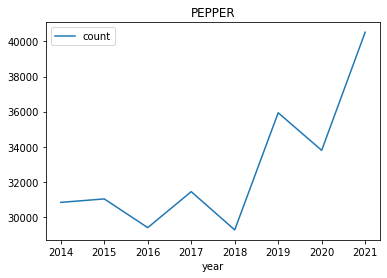

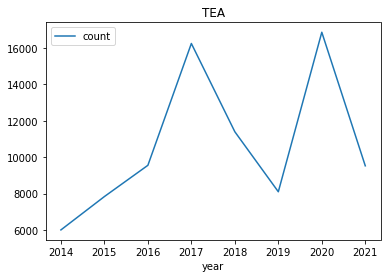

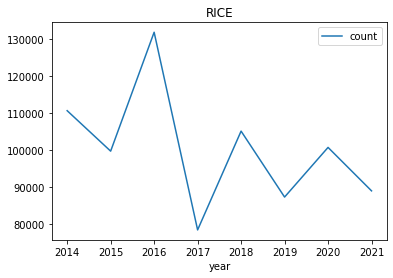

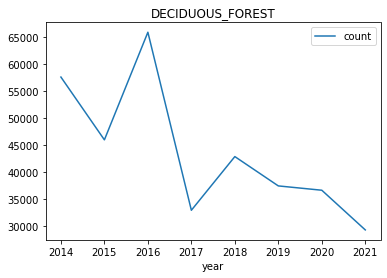

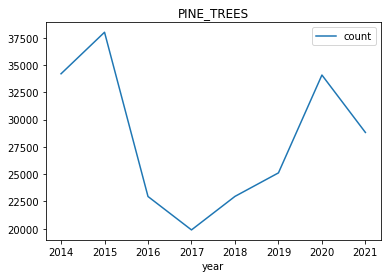

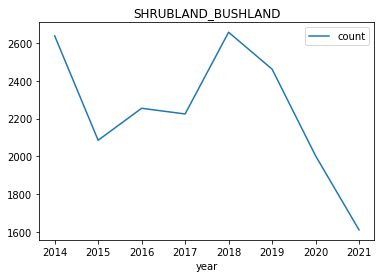

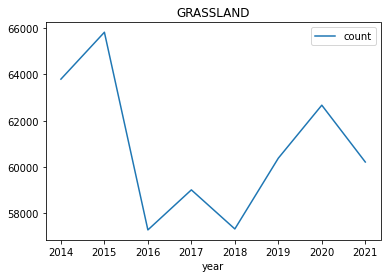

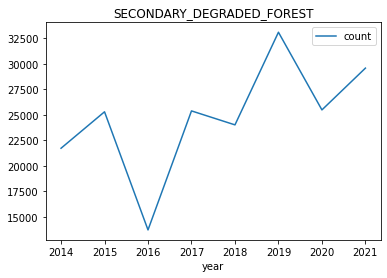

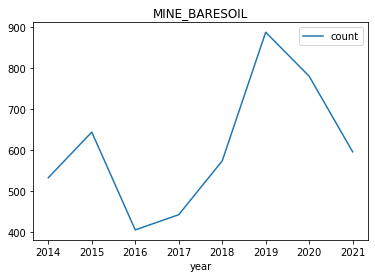

In [12]:
for label in labels:
    total_per_year_df[total_per_year_df['label_predicted'] == labels.index(label)][['count', 'year']].plot(x="year", title=label.name)

In [13]:
LABELS_COORDINATES = vietnam_labels_coordinates()
raster_example = rasterio.open(os.path.join(DATA_ROOT_PATH, "Vietnam_2018_january_to_april_collection2/merged.tif"))

In [47]:
concat_df = pd.read_csv(os.path.join(DATA_ROOT_PATH, 'final_predictions_january_to_april_2014_2021.csv'))
map_width = int(concat_df.agg(['max'], column='image col')['image col']) + 1
map_height = int(concat_df.agg(['max'], column='image row')['image row']) + 1
    
def draw_image(img, cmap):
    img = np.ma.masked_where(img == 0, img)

    dpi = 96
    plt.close()
    plt.figure(figsize=((map_width / dpi), (map_height / dpi)))
    plt.imshow(img, aspect="auto", vmin=1, cmap=cmap, interpolation='nearest')
    
def save_visualization_to_disk(arr, raster_example, filename, upscale_factor=9):
    filepath = os.path.join(DATA_ROOT_PATH, filename)

    metadata = raster_example.meta.copy()
    metadata.update({
        "driver": "GTiff",
        "height": arr.shape[0] * upscale_factor,
        "width": arr.shape[1] * upscale_factor,
        "transform": raster_example.transform,
        "crs": raster_example.crs
    })

    # Write merged raster to disk
    with rasterio.open(filepath, "w", **metadata) as dest:        
        dest.write(arr, indexes=1)
    
def first_prediction_year():
    img = np.zeros((map_height, map_width))
    
    points_x = concat_df[concat_df.year == 2018]['image col'].tolist()
    points_y = concat_df[concat_df.year == 2018]['image row'].tolist()

    coffee_first_detections = label_first_detections(
        os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif'),
        concat_df,
        labels.index(Label.COFFEE),
        LABELS_COORDINATES[Label.COFFEE.value]
    )
    
    colors = ['black', 'silver', 'yellow', 'olive', 'lime', 'green', 'fuchsia', 'purple', 'red', 'maroon']
    cmap = ListedColormap(colors)
    
    coffe_first_detections = pd.DataFrame(coffee_first_detections, columns=['row', 'col', 'year'])
    
    nan_list = coffe_first_detections[(coffe_first_detections.year == 'nan')][['row', 'col']]
    nan_detection_x = nan_list.col.to_list()
    nan_detection_y = nan_list.row.to_list()
    
    for i in range(len(points_x)):
        x = points_x[i]
        y = points_y[i]
        
        img[y][x] = 1
        
    for i in range(len(nan_detection_x)):
        x = nan_detection_x[i]
        y = nan_detection_y[i]
        
        img[y][x] = 2

    for year in range(14, 22):
        detection_list = coffe_first_detections[(coffe_first_detections.year == 2000 + year)][['row', 'col']]
        detection_list_x = detection_list.col.to_list()
        detection_list_y = detection_list.row.to_list()
        
        print(f"{2000 + year}: {colors[year-12]}")
                
        for i in range(len(detection_list_x)):
            x = detection_list_x[i]
            y = detection_list_y[i]

            img[y][x] = year - 11
            
    draw_image(img, cmap)
    save_visualization_to_disk(img, raster_example, 'first_prediction_year.tiff')
    
def year_coffee_prediction(year):
    img = np.zeros((map_height, map_width))

    year_df = concat_df[concat_df['year'] == year]
    
    other_points = year_df[year_df['label_predicted'] != labels.index(Label.COFFEE)]
    other_points_x = other_points['image col'].to_list()
    other_points_y = other_points['image row'].to_list()
    
    coffee_points = year_df[year_df['label_predicted'] == labels.index(Label.COFFEE)]
    coffee_points_x = coffee_points['image col'].to_list()
    coffee_points_y = coffee_points['image row'].to_list()
    
    # Known coffee points
    row_col_coffee_labels = []

    with rasterio.open(os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')) as raster:
        row_col_coffee_labels = [raster.index(coord[0], coord[1], precision=23) for coord in LABELS_COORDINATES[Label.COFFEE.value]]
    
    for other_point_index in range(len(other_points)):
        x = other_points_x[other_point_index]
        y = other_points_y[other_point_index]

        img[y][x] = 1

    for coffee_point_index in range(len(coffee_points)):
        x = coffee_points_x[coffee_point_index]
        y = coffee_points_y[coffee_point_index]

        img[y][x] = 2
        
    for row_col in row_col_coffee_labels:
        x = round(row_col[1] / 9)
        y = round(row_col[0] / 9)

        img[y][x] = 3
    
    cmap = ListedColormap(["black", "green", "red"])
    draw_image(img, cmap)

def year_category_predictions(year):
    img = np.zeros((map_height, map_width))

    year_df = concat_df[concat_df['year'] == year]
    
    colors = ['green', 'saddlebrown', 'black', 'blue', 'darkgreen', 'maroon']
    cmap = ListedColormap(colors)

    for label in LabelCategory:
        points = year_df[year_df['category_predicted'] == categories.tolist().index(label)]
        points_x = points['image col'].to_list()
        points_y = points['image row'].to_list()
        
        print(f"{label.name}: {label.value}, {colors[label.value]}")
        
        for i in range(len(points)):    
            img[points_y[i]][points_x[i]] = label.value + 1
            
    # Known coffee points
    row_col_coffee_labels = []

    with rasterio.open(os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')) as raster:
        row_col_coffee_labels = [raster.index(coord[0], coord[1], precision=23) for coord in LABELS_COORDINATES[Label.COFFEE.value]]
    
    for row_col in row_col_coffee_labels:
        x = round(row_col[1] / 9)
        y = round(row_col[0] / 9)

        img[y][x] = 6
    
    draw_image(img, cmap)

def forest_replaced_by_coffee(reference_year=2018):
    df = concat_df[concat_df['year'] == reference_year]

    # Select all forest tiles from 2018 and see how many times coffee appears after that    
    df = df.loc[df['label_predicted'].isin(
        [labels.index(forest_label) for forest_label in CATEGORIES_LABELS[LabelCategory.FOREST]]
    )]
    
    col_list = df["image col"].tolist()
    row_list = df["image row"].tolist()

    # filter years after reference_year and take only images with row-col where forest where in 2018   
    df = concat_df[concat_df['year'] > reference_year]
    df = df[
        df
            .set_index(['image row','image col'])
            .index.isin(list(zip(row_list, col_list)))
    ]

    # counts number of occurences of coffee at each row and col where forest was present in 2018
    df = df[df['label_predicted'] == labels.index(Label.COFFEE)]
    df = df.groupby(['image row','image col']).size().reset_index(name='counts')

    # create image with a different color based on the number of occurences of coffee that replaced forest  
    img = np.zeros((map_height, map_width))

    for _, position in df.iterrows():
        img[position['image row']][position['image col']] = position['counts']

    draw_image(img, 'Reds')

def forest_replaced_by_culture(reference_year=2018):
    df = concat_df[concat_df['year'] == reference_year]

    # Select all forest tiles from a year of reference and see how many times culture appears after that
    df = df[df['category_predicted'] == categories.tolist().index(LabelCategory.FOREST)]
    col_list = df["image col"].tolist()
    row_list = df["image row"].tolist()

    # Select every years after reference year
    df = concat_df[concat_df['year'] > reference_year]
    
    # Select only images with row-col where forest where in 2018   
    df = df[
        df
            .set_index(['image row','image col'])
            .index.isin(list(zip(row_list, col_list)))
    ]

    df = df[df['category_predicted'] == categories.tolist().index(LabelCategory.CULTURE)]
    df = df.groupby(['image row','image col']).size().reset_index(name='counts')

    img = np.zeros((map_height, map_width))

    for _, position in df.iterrows():
        img[position['image row']][position['image col']] = position['counts']

    draw_image(img, 'Reds')

In [21]:
print("Coffee prediction")
widgets.interact_manual(year_coffee_prediction, year=widgets.IntSlider(min=2014, max=2021, step=1));

Coffee prediction


interactive(children=(IntSlider(value=2014, description='year', max=2021, min=2014), Button(description='Run I…

In [48]:
print("Category prediction")
widgets.interact_manual(year_category_predictions, year=widgets.IntSlider(min=2014, max=2021, step=1));

Category prediction


interactive(children=(IntSlider(value=2014, description='year', max=2021, min=2014), Button(description='Run I…

2014: yellow
2015: olive
2016: lime
2017: green
2018: fuchsia
2019: purple
2020: red
2021: maroon


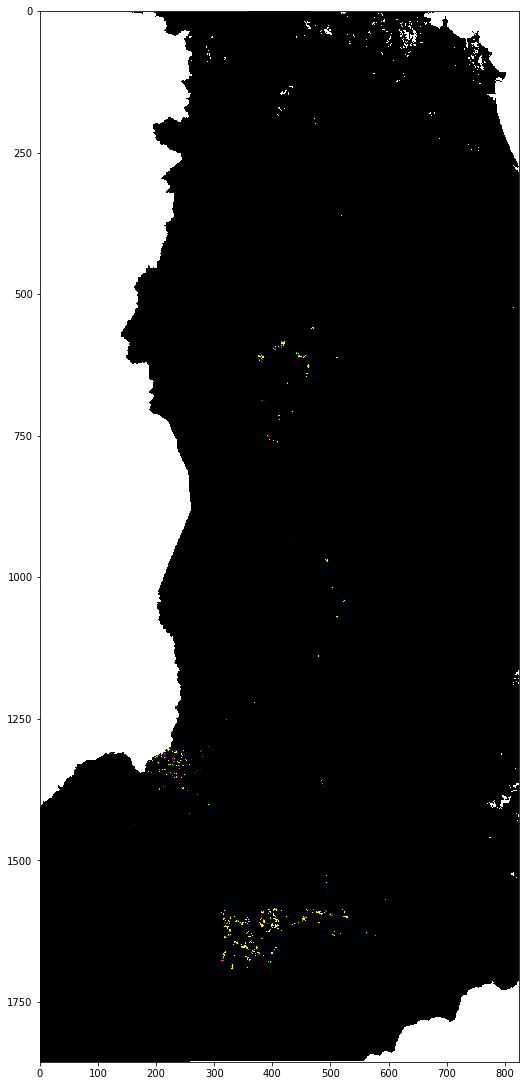

In [23]:
first_prediction_year()

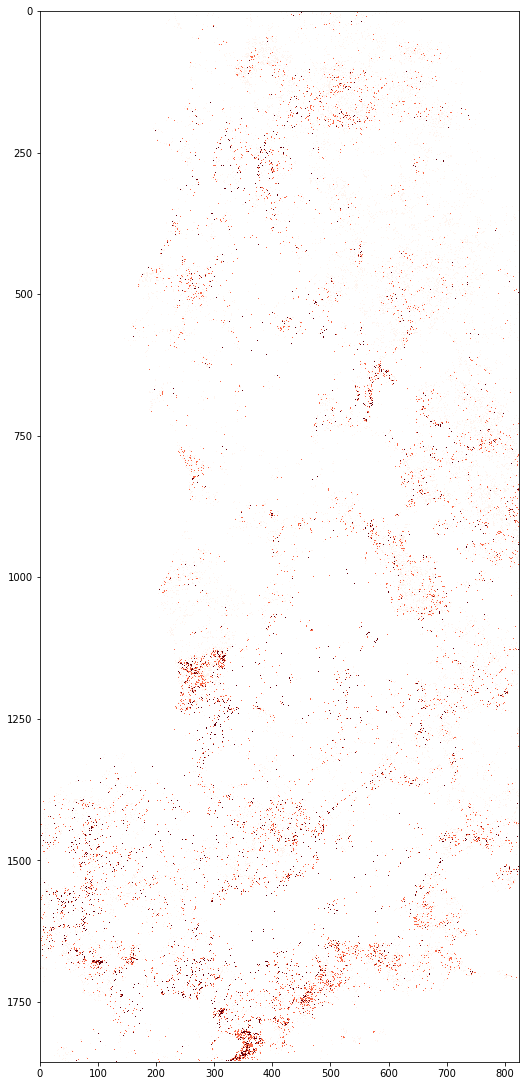

In [24]:
forest_replaced_by_coffee()

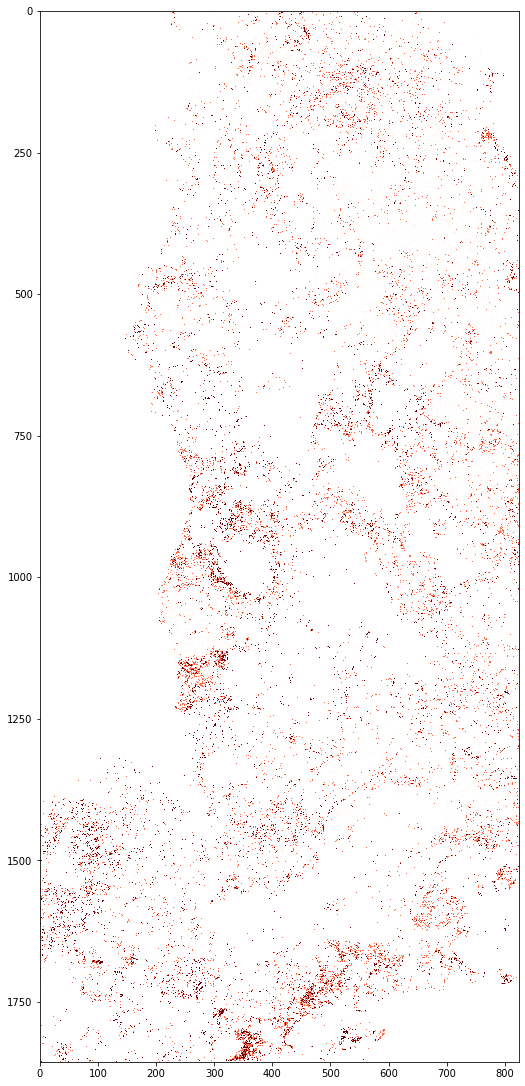

In [46]:
forest_replaced_by_culture()